# Pinch Off Measurement with DC and AC and Hall Measurement

## Imports

In [1]:
# Copy this to all notebooks!
from qcodes.logger import start_all_logging
start_all_logging()

# Import qcodes and other necessary packages
import qcodes as qc
import numpy as np
import time

# Import device drivers 
from qcodes.instrument_drivers.tektronix.Keithley_2600_channels import Keithley_2600
from qcodes.instrument_drivers.QuantumDesign.DynaCoolPPMS import DynaCool
from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
from qcodes.instrument_drivers.stanford_research.SR830 import SR830
from qcodes.instrument_drivers.Keysight.Infiniium import Infiniium


from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.database import initialise_database
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.experiment_container import load_experiment_by_name
from qcodes.instrument.base import Instrument

import matplotlib.pyplot as plt
import matplotlib
from time import sleep
from qcodes.dataset.data_export import flatten_1D_data_for_plot

#from qdev_wrappers.dataset.doNd import do1d,do2d


Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lyn-ppmsmsr-01usr\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\lyn-ppmsmsr-01usr\.qcodes\logs\200710-532-qcodes.log
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lyn-ppmsmsr-01usr\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


2020-07-10 17:22:26,659 ¦ py.warnings ¦ WARNING ¦ warnings ¦ _showwarnmsg ¦ 110 ¦ C:\Users\lyn-ppmsmsr-01usr\miniconda3\envs\qcodes\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'



Qcodes Logfile : C:\Users\lyn-ppmsmsr-01usr\.qcodes\logs\200710-532-qcodes.log


## Station

In [2]:
# Create station, instantiate instruments
Instrument.close_all()
station = qc.Station()
# Connect to ppms
#Instrument.find_instrument('ppms_cryostat')
ppms = DynaCool.DynaCool(name = "ppms_cryostat", address="TCPIP0::10.10.117.37::5000::SOCKET")
station.add_component(ppms)

# Connect to Keithley
keith = Keithley_2600(name="KL", address="TCPIP0::192.168.15.101::inst0::INSTR")
keith.smua.volt(0) # Set voltages to 0
keith.smub.volt(0) # Set voltages to 0
station.add_component(keith)
#for inst in station.components.values():
#    inst.print_readable_snapshot()

# Connect to Keysight
#keys = Keysight_34465A(name="KS", address="TCPIP0::K-34465A-06744::inst0::INSTR")
#station.add_component(keys)

#Connect to Lock in amplifier
sr830 = SR830('SR830', 'GPIB0::1::INSTR')
sr830M = SR830('SR830M', 'GPIB0::2::INSTR')
station.add_component(sr830)
station.add_component(sr830M)


Connected to:  QuantumDesign dynacool (serial:N/A, firmware:N/A) in 0.22s
Connected to: Keithley Instruments Inc. 2614B (serial:4376445, firmware:3.2.2) in 0.02s
Connected to: Stanford_Research_Systems SR830 (serial:s/n91493, firmware:ver1.07) in 0.10s
Connected to: Stanford_Research_Systems SR830 (serial:s/n91797, firmware:ver1.07) in 0.03s


'SR830M'

In [3]:
for inst in station.components.values():
    inst.print_readable_snapshot()

ppms_cryostat:
	parameter           value
--------------------------------------------------------------------------------
IDN                  :	{'vendor': ' QuantumDesign', 'model': 'dynacool', 'ser...
chamber_state        :	sealed 
chamber_temperature  :	1.6999 (K)
field_approach       :	linear 
field_measured       :	9.8738e-06 (T)
field_ramp           :	None (T)
field_rate           :	0 (T/s)
field_target         :	9.8738e-06 (T)
field_tolerance      :	0.0005 (T)
magnet_state         :	holding 
temperature          :	1.6999 (K)
temperature_rate     :	0.016667 (K/s)
temperature_setpoint :	1.7 (K)
temperature_settling :	no overshoot 
temperature_state    :	stable 
timeout              :	5 (s)
KL:
	parameter      value
--------------------------------------------------------------------------------
IDN             :	{'vendor': 'Keithley Instruments Inc.', 'model': '2614B', '...
display_settext :	None 
timeout         :	5 (s)
KL_smua:
	parameter                  value
----------------

## DB File, Location and Functions

In [4]:
#config.save_to_home  ### Initialize database, make new measurement
%matplotlib notebook

from qcodes.dataset.database import get_DB_location
from qcodes import config
import os.path
import os

mainpath = 'C:/Users/MicrosoftQ/Desktop/Results'
config.current_config.core.db_location = os.path.join(mainpath,'MQML263_AB_1BD_200710.db')
config.current_config
newpath = os.path.join(mainpath,'MQML263_AB_1BD_200710')  
if not os.path.exists(newpath):
    os.makedirs(newpath)
figurepath = newpath
initialise_database()


# DIFFERENTIAL CONDUCTANCE FOR A TWO PROBE MEASUREMENT

ac_divider     = 1e-4
gain_curr_ampl = 1e6

def desoverh():
    volt_ampl = sr830.amplitude
    amplitude_curr = sr830.R
    dcond = (amplitude_curr()/gain_curr_ampl)/(volt_ampl()*ac_divider)/go
    return dcond     
    
try:
    sr830.add_parameter("diff_conductance", label="dI/dV", unit="2e^2/h", get_cmd = desoverh)
except KeyError:
    print("parameter already exists. Deleting. Try again")
    del sr830.parameters['diff_conductance']

#------------------------------------------------------------------------
def wait_for_field():
    time.sleep(0.1)
    Magnet_state = ppms.magnet_state()
    while Magnet_state is not 'holding':
        #print('waiting for field')
        time.sleep(0.1)
        Magnet_state = ppms.magnet_state()
        #print('field ready')
    return

def wait_for_field_ramp():
    Magnet_state = ppms.magnet_state()
    while Magnet_state is not 'ramping':
        time.sleep(0.1)
        Magnet_state = ppms.magnet_state()
    return

def field_ready():
    return ppms.magnet_state() == 'holding'

def wait_for_temp():
    Temp_state = ppms.temperature_state()
    while Temp_state is not 'stable':
        time.sleep(1)
        Temp_state = ppms.temperature_state()
    return


#--------------------------------------------------------------------------
#fig, ax = plt.subplots(1)
#fig2, ax2 = plt.subplots(1)

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 570.27it/s]


# Frequency test

In [ ]:
#   Rough scan

new_experiment(name='lockin_start_up', sample_name='devX_rough_scan')


# Use whichever lock-in you are interested (lockin_X) or whatever name has
frequency = lockin_1.frequency            
amplitude = lockin_1.R

f_min  = 15
f_max  = 140
Nfreq  = 100
Ntimes = 50

# f_min = 10 Hz  => t_c = 1/15*5 => t_c = 300 ms
lockin_1.time_constant(0.3)
tdelay = 1

dc_divider     = 1e-2
ac_divider     = 1e-4
gain_curr_ampl = 1e6

dmm_a.smua.output('on')                   # Turn on the bias channel
dmm_a.smub.output('on')                   # Turn on the gate channel

dmm_a.smub.volt(0.1e-3/dc_divider)        # Set a small DC signal ie 0.1mV
dmm_a.smub.volt(-20)                      # Set the gate on a very high resistance area (below the pinch-off)

do2d(frequency, f_min,   f_max,  Nfreq, tdelay,
    counts,     1    , Ntimes , Ntimes, 0.01,
    amplitude)

In [ ]:
#   Fine scan

new_experiment(name='lockin_start_up', sample_name='devX_fine_scan')


# Use whichever lock-in you are interested (lockin_X) or whatever name has
frequency = lockin_1.frequency            
amplitude = lockin_1.R

f_min  = 58
f_max  = 72
Nfreq  = 50
Ntimes = 100

# f_min = 60 Hz  => t_c = 1/60*5 => t_c = 100 ms
lockin_1.time_constant(0.1)
tdelay = 0.5

dc_divider     = 1e-2
ac_divider     = 1e-4
gain_curr_ampl = 1e6

dmm_a.smua.output('on')                   # Turn on the bias channel
dmm_a.smub.output('on')                   # Turn on the gate channel

dmm_a.smub.volt(0.1e-3/dc_divider)        # Set a small DC signal ie 0.1mV
dmm_a.smub.volt(-20)                      # Set the gate on a very high resistance area (below the pinch-off)

do2d(frequency, f_min,   f_max,  Nfreq, tdelay,
    counts,     1    , Ntimes , Ntimes, 0.01,
    amplitude)

## Plots Definition

In [32]:
def do1d(param_set, start, stop, num_points, delay, *param_meas):
    meas = Measurement()
    meas.register_parameter(param_set)  # register the first independent parameter
    output = []
    param_set.post_delay = delay
    # do1D enforces a simple relationship between measured parameters
    # and set parameters. For anything more complicated this should be reimplemented from scratch
    for parameter in param_meas:
        meas.register_parameter(parameter, setpoints=(param_set,))
        output.append([parameter, None])

    with meas.run() as datasaver:
        for set_point in np.linspace(start, stop, num_points):
            param_set.set(set_point)
            #wait_for_temp()
            for i, parameter in enumerate(param_meas):
                output[i][1] = parameter.get()
            datasaver.add_result((param_set, set_point),
                                 *output)
    dataid = datasaver.run_id  # convenient to have for plotting
    return dataid


def do2d(param_set1, start1, stop1, num_points1, delay1, 
         param_set2, start2, stop2, num_points2, delay2,
         *param_meas):
    # And then run an experiment

    meas = Measurement()
    meas.register_parameter(param_set1)
    param_set1.post_delay = delay1
    meas.register_parameter(param_set2)
    param_set2.post_delay = delay2
    output = [] 
    for parameter in param_meas:
        meas.register_parameter(parameter, setpoints=(param_set1,param_set2))
        output.append([parameter, None])

    with meas.run() as datasaver:
        for set_point1 in np.linspace(start1, stop1, num_points1):
            param_set1.set(set_point1)
            for set_point2 in np.linspace(start2, stop2, num_points2):
                param_set2.set(set_point2)
                wait_for_field()
                #wait_for_temp()
                for i, parameter in enumerate(param_meas):
                    output[i][1] = parameter.get()
                datasaver.add_result((param_set1, set_point1),
                                     (param_set2, set_point2),
                                     *output)
    dataid = datasaver.run_id  # convenient to have for plotting
    return dataid

## 1D & 2D Plot for Hall Measurement

In [24]:
keith.smub.output('on')
gate = keith.smub.volt

magnetic_field = ppms.field_ramp
#magnetic_field = ppms.field_setpoint
ppms.field_rate(0.22)

temperature = ppms.temperature_setpoint
ppms.temperature_rate(0.3)
new_experiment(name='HB_1-10_90', sample_name='_S13D10HR14LR16HX16LX11_T1p7K_B0T_Vg2to-2V_Isd10nA_Vg_Sweep 2')

# Scan with Magnetic Field
#gate()
#do1d(magnetic_field, -1.5, 1.5, 1501, 1, sr830.R, sr830M.X)

    # Scan with Gate voltage
#magnetic_field(0)
#temperature(1.7)
do1d(gate, 2, -2, 401, 1, sr830.R, sr830M.X)

    # Scan with Temperature
#magnetic_field(0)
#gate(1.5)
#do1d(temperature, 1.7, 301.7, 301, 1, sr830.R,sr830M.X)

   # 2D scan with Gate voltage and Magnetic Field
#do2d(gate, -0.5, 2, 11, 1,
#     magnetic_field, -1.5, 1.5, 1501, 1,
#         sr830.R,sr830M.X)

   # 2D scan with Temperature and Magnetic Field
#do2d(temperature, 1.7, 301.7, 61, 1,
#     magnetic_field, -1.5, 1.5, 61, 1,
#         sr830.R,sr830M.X)


Starting experimental run with id: 109. 


109

In [39]:
keith.smub.output('off')
keith.smub.volt(0)
ppms.field_target(0)
ppms.field_rate(0.22)
ppms.ramp('non-blocking')

#ppms.temperature_setpoint(1.7)

In [78]:
sensitivity1   = 200 * 1e-3 # V
sensitivity2   = 200 * 1e-3 # V

sr830.sensitivity(sensitivity1) 
sr830M.sensitivity(sensitivity2) 

<IPython.core.display.Javascript object>


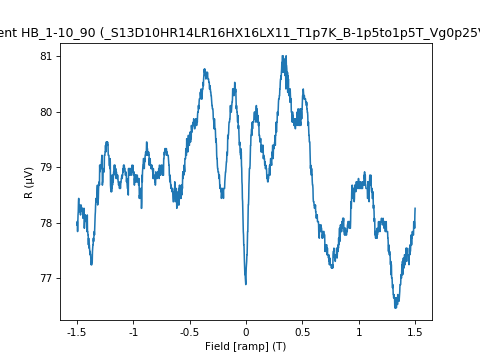

<IPython.core.display.Javascript object>


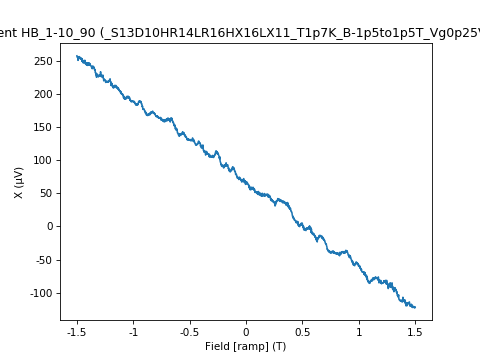

([<matplotlib.axes._subplots.AxesSubplot at 0x22bdf1e4e08>,
 [None, None])

In [58]:
plot_by_id(97)

## 1D & 2D Plot for FE & Hall Measurement with DC

In [53]:
keith.smua.output('on')
keith.smub.output('on')

bias = keith.smua.volt
gate = keith.smub.volt
current = keith.smua.curr
leakage = keith.smub.curr

keith.smua.volt(0.001)
#bias_setpoint = 1* 1e-3 #mV

magnetic_field = ppms.field_ramp
#magnetic_field = ppms.field_setpoint
ppms.field_rate(0.22)

temperature = ppms.temperature_setpoint
ppms.temperature_rate(0.3)

new_experiment(name='MQML263AB_FE_1-10_2P', sample_name='_S01D06G05_T1p7K_B-1to1T_Vg-1p5to2V_Vsd1mV_Vg_B_Sweep')

# Scan with Magnetic Field
#gate()
#do1d(magnetic_field, -9, 9, 9001, 1, current, leakage)

    # Scan with Gate voltage
#magnetic_field(0)
#temperature(1.7)
#do1d(gate, 2, -2, 401, 0.5, current, leakage)

    # Scan with Temperature
#magnetic_field(0)
#gate(1.5)
#do1d(temperature, 1.7, 300, 301, 1, current,leakage)

    # 2D scan with Gate voltage and Magnetic Field
do2d(gate, -1.5, 2, 15, 1,
     magnetic_field, -1, 1, 1001, 1,
         current, leakage)

    # 2D scan with Magnetic Field and Gate voltage
#do2d(magnetic_field, 0, 9, 19, 1,
#     gate, 5, -2, 401, 2,
#         current, leakage)

    # 2D scan with Temperature and Magnetic Field
#do2d(temperature, 1.7, 301.7, 61, 1,
#     magnetic_field, -2.5, 2.5, 101, 1,
#         current, leakage)

#keith.smua.output('off')
#keith.smub.output('off')

Starting experimental run with id: 28. 


2020-07-13 10:43:10,475 ¦ qcodes.dataset.measurements ¦ WARNING ¦ measurements ¦ __exit__ ¦ 693 ¦ An exception occured in measurement with guid: aaaaaaaa-0100-0001-0000-0173455825b3;
Traceback:
Traceback (most recent call last):
  File "<ipython-input-32-5fe12eea5a5e>", line 43, in do2d
    param_set2.set(set_point2)
  File "C:\Users\lyn-ppmsmsr-01usr\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\parameter.py", line 631, in set_wrapper
    set_function(raw_val_step, **kwargs)
  File "C:\Users\lyn-ppmsmsr-01usr\miniconda3\envs\qcodes\lib\site-packages\qcodes\utils\command.py", line 178, in __call__
    return self.exec_function(*args)
  File "C:\Users\lyn-ppmsmsr-01usr\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument_drivers\QuantumDesign\DynaCoolPPMS\DynaCool.py", line 284, in _field_ramp_setter
    self.ramp(mode='blocking')
  File "C:\Users\lyn-ppmsmsr-01usr\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument_drivers\QuantumDesign\DynaCoolPPMS\DynaCool.p

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


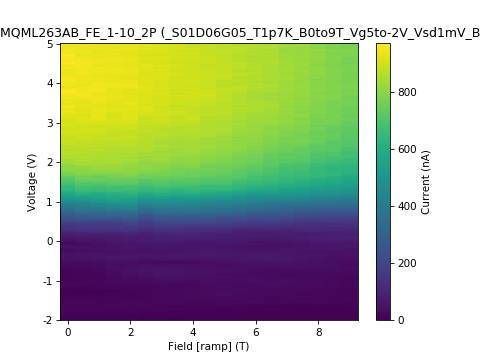

<IPython.core.display.Javascript object>


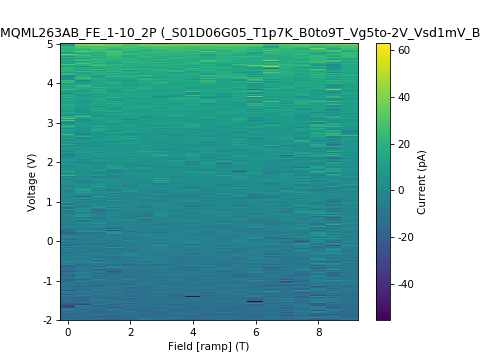

([<matplotlib.axes._subplots.AxesSubplot at 0x215f2e46248>,
  <matplotlib.colorbar.Colorbar at 0x215f1cca988>])

In [50]:
plot_by_id(27)

In [55]:
keith.smub.output('off')
keith.smua.output('off')
keith.smub.volt(0)
keith.smua.volt(0.001)
ppms.field_target(0)
ppms.field_rate(0.22)
ppms.ramp('non-blocking')
#ppms.temperature_setpoint(1.7)

In [10]:
   # Scan with 2D temperature sweep
    
# Turn on the instruments
keith.smub.output('on')

# Set parameter values
gate_start = -12 #V
gate_end = 20 #V
Npoints = 1500

time_constant = 300 * 1e-3 # ms
sensitivity   = 100 * 1e-3 # mV
frequency     = 18         # Hz
filter_slope  = 12         # dB
amplitude     = 1          # V 

sr830.time_constant(time_constant)  # set time constant on the lock-in
sr830.sensitivity(sensitivity)      # set sensitivity on the lock-in
sr830.frequency(frequency)          # set frequency on the lock-in
sr830.amplitude(amplitude)          # set amplitude on the lock-in
sr830.filter_slope(filter_slope)    # set filter slope on the lock-in

dividerAC = 1e4       # the AC voltgade divider
gain = 1e6        # gain of the current amplifier gain=V/I used 

temperature = 1.7 #K
magnetic_field = 0 #T

timedelay = 0.1 #

#paramrange = np.linspace(0,9,10)  # 1.0 step
#paramrange = np.linspace(0,9,19)  # 0.5 step
#paramrange = np.linspace(0,9,46)  # 0.2 step
#paramrange = np.linspace(0,9,181) # 0.05 step
#paramrange = np.linspace(2,20,19) #for temperature
paramrange = [0] #arbitrary values

# Run
for var_param in paramrange:
    magnetic_field = var_param    
    ppms.field_setpoint(magnetic_field)
    ppms.temperature_setpoint(temperature)
    wait_for_field()
    #wait_for_temp() 
    time.sleep(10)
    
    Experiment_name = "_AC_ZeroBias"+"T"+"{:.1f}".format(temperature)+"K_B"+"{:.1f}".format(magnetic_field)+"T"
    Sample_name = "QDev878_Device5_T1_00_00-00"
    
    new_experiment(name=Experiment_name+' up', sample_name = Sample_name)
    do1d(gate,gate_start,gate_end,Npoints,timedelay,chan_a,chan_b,leakage,dcond)
    
    new_experiment(name=Experiment_name+' down', sample_name = Sample_name)
    do1d(gate,gate_end,gate_start,Npoints,timedelay,chan_a,chan_b,leakage,dcond)

# Turn off the instruments    
gate(0)
keith.smub.output('off')
#ppms.field_setpoint(0)"""

c:\users\quantum_ppms\documents\qcodes source\qcodes\qcodes\instrument_drivers\QuantumDesign\DynaCoolPPMS\DynaCool.py:309: UserWarning: The "field_setpoint" parameter is deprecated. Please use the "field_target" parameter and the "ramp" method instead.
  warnings.warn('The "field_setpoint" parameter is deprecated. Please '


KeyboardInterrupt: 

## Pinch-off curves DC using Keithley only

Normal sweep without live plotting. Results are shown when each sweep is finished.

Starting experimental run with id: 44. 
Could not update QCPlot live plot. Is QCPlot running?
Could not update QCPlot live plot. Is QCPlot running?
Could not update QCPlot live plot. Is QCPlot running?
done sweeping up


<IPython.core.display.Javascript object>


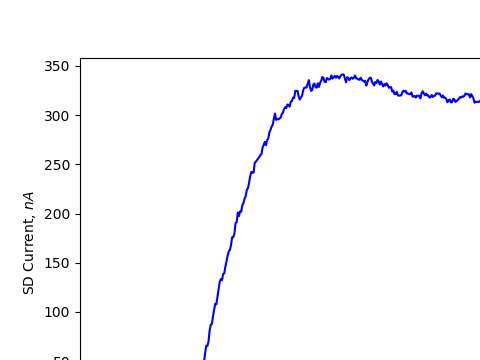

<IPython.core.display.Javascript object>


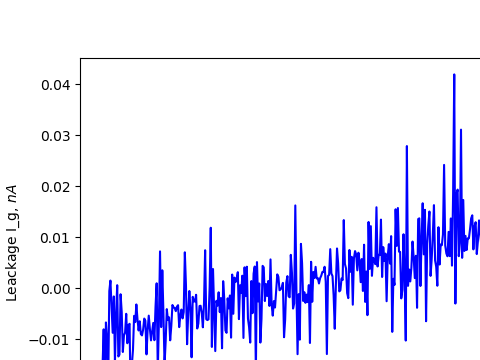

done plotting up data
Starting experimental run with id: 45. 


In [ ]:
keith.smua.output('on')
keith.smub.output('on')

# define new names for Keithley channels
bias=keith.smua.volt
gate=keith.smub.volt
current = keith.smua.curr
leakage = keith.smub.curr

# to give the parameter numbers
bias_setpoint = 1* 1e-3 #mV

gate_start = -2 #V
gate_end = 5 #V
Npoints = 401

temperature = 1.7 #K
magnetic_field = 0 #T


timedelay = 0.5 #S
Experiment_name = '_S29D31G30_T1p7K_B0T_Vg-2to5V_Vsd1mV_Pinch_Off_3'
Sample_name = "MQML263AB_FE_100_2P"

meas = Measurement()
meas.write_period = timedelay

#----------------------------------------------------------------------------------------------------------
meas.register_parameter(gate)  # register independent parameter
meas.register_parameter(current, setpoints=(gate,))  # now register the dependent one
meas.register_parameter(leakage, setpoints=(gate,))     # now register the dependent one
meas.register_parameter(bias, setpoints=(gate,))   # now register the dependent one

meas.add_before_run(lambda: ppms.field_target(magnetic_field), ())  # set magnetic field
meas.add_before_run(lambda: ppms.ramp(mode='blocking'), ())  # set magnetic field
meas.add_before_run(lambda: ppms.temperature_setpoint(temperature), ())  # set temperature
#meas.add_before_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize
#meas.add_before_run(lambda: wait_for_temp(), ())  # wait for temperature to stabilize
meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s

meas.add_before_run(lambda: keith.smua.output('on'), ())  # Turn Keithley output A on
meas.add_before_run(lambda: keith.smub.output('on'), ())  # Turn Keithley output B on

meas.add_before_run(lambda: bias(bias_setpoint), ())  # set bias to defined value
meas.add_before_run(lambda: time.sleep(0.1), ())  # delay 1s


#meas.add_after_run(lambda: bias(0), ())  # Set bias to 0
meas.add_after_run(lambda: keith.smua.output('off'), ())  # Turn Keithley output A off
#meas.add_after_run(lambda: keith.smub.output('off'), ())  # Turn Keithley output B off

# Sweep up gate without plotting
# This measurement just saves the gate voltage array set (not the actual value),
# the measured current and the gate leakage
new_experiment(name=Experiment_name+' up', sample_name = Sample_name)
with meas.run() as datasaver:
    for gate_setpoint in np.linspace(gate_start, gate_end, Npoints):
        gate(gate_setpoint)
        V_g = gate()
        I_sd = current()
        I_g = leakage()
        V_sd = bias()              
        datasaver.add_result((gate, V_g), (current, I_sd), (leakage, I_g), (bias, V_sd))
        time.sleep(timedelay)    #sleep
    dataid_up = datasaver.run_id  # convenient to have for plotting 
print("done sweeping up")
# Plotting the measured data for sweeping up
# PLOT 1: I-V
# PLOT 2: L-V           
dataset = qc.load_by_id(dataid_up)
labels = dataset.parameters.split(",")

mydata = dataset.get_parameter_data()

v = mydata[labels[1]][labels[0]] #V
c = mydata[labels[1]][labels[1]]*1e9 # nA 
l = mydata[labels[2]][labels[2]]*1e9 # nA

# v = flatten_1D_data_for_plot(dataset.get_dat(labels[0])) #V
# c = flatten_1D_data_for_plot(dataset.get_data(labels[1]))*1e9 # nA 
# l = flatten_1D_data_for_plot(dataset.get_data(labels[2]))*1e9 # nA

fig1,ax1 = plt.subplots(1,1)
ax1.set_xlabel(r'Gate voltage $V_g$, V')
ax1.set_ylabel(r'SD Current, $nA$')
ax1.plot(v,c,'b-')
fig1.canvas.draw()
fig1.tight_layout()

fig2,ax2 = plt.subplots(1,1)
ax2.set_xlabel(r'Gate voltage $V_g$, V')
ax2.set_ylabel(r'Leackage I_g, $nA$')
ax2.plot(v,l,'b-')  
fig2.canvas.draw()
fig2.tight_layout()

print("done plotting up data")

# Sweep down gate without plotting
# This measurement just saves the gate voltage array set (not the actual value),
# the measured current and the gate leakage
new_experiment(name=Experiment_name+' down', sample_name = Sample_name)
with meas.run() as datasaver:
    for gate_setpoint in np.linspace(gate_end, gate_start, Npoints):
        gate(gate_setpoint)
        V_g = gate()
        I_sd = current()
        I_g = leakage()
        V_sd = bias()              
        datasaver.add_result((gate, V_g), (current, I_sd), (leakage, I_g), (bias, V_sd))
        time.sleep(timedelay)    #sleep
    dataid_down = datasaver.run_id  # convenient to have for plotting 
print("done sweeping down")
# Plotting the measured data for sweeping down
# PLOT 1: I-V
# PLOT 2: L-V           
dataset = qc.load_by_id(dataid_down)
labels = dataset.parameters.split(",")


mydata = dataset.get_parameter_data()

v = mydata[labels[1]][labels[0]] #V
c = mydata[labels[1]][labels[1]]*1e9 # nA 
l = mydata[labels[2]][labels[2]]*1e9 # nA

# v = flatten_1D_data_for_plot(dataset.get_data(labels[0])) #V
# c = flatten_1D_data_for_plot(dataset.get_data(labels[1]))*1e9 # nA 
# l = flatten_1D_data_for_plot(dataset.get_data(labels[2]))*1e9 # nA

ax1.plot(v,c,'r-')
fig1.canvas.draw()

ax2.plot(v,l,'r-')  
fig2.canvas.draw()
 
plt.figure(fig1.number)          
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+' Isd.png')
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+' Isd.svg')

plt.figure(fig2.number)
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+' Ig.png')
#plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+' Ig.svg')


In [92]:
# After run setup
#keith.smua.output('off')
keith.smub.output('on')
keith.smub.volt(-2)
ppms.field_target(0)
#temperature(1.7)

In [40]:
Qconductance = (745e-9/10e-3)/7.7480917e-05
print (Qconductance)

0.961527081565129


## 2D sweep of bias and gate voltage using Keithley only for DC measurement

In [16]:
# define new names for Keithley channels
bias=keith.smua.volt
gate=keith.smub.volt
current = keith.smua.curr
leakage = keith.smub.curr

# Bias range
bias_start  =  -30* 1e-3 #mV
bias_end    =  30* 1e-3 #mV
Nbiaspoints =  101

# Gate range
gate_start  = 5 #V
gate_end    = -15 #V
Npoints     = 101

temperature    = 1.7 #K
magnetic_field = 9000 * 1e-3 #mT

timedelay = 0.1 #s

Experiment_name = "  E17E18  B9T T1p7K time 0p1 Vsd-30to30mV p101 Vg5to-15V p101 "                                  
Sample_name = "chipa3 9T 1p7K "

new_experiment(name = Experiment_name, sample_name = Sample_name)
meas = Measurement()
meas.register_parameter(bias)  # register the first independent parameter
meas.register_parameter(gate)  # register the second independent parameter

#meas.register_parameter(quant_cond, setpoints=(bias, gate,))  # now register the dependent one
meas.register_parameter(current,    setpoints=(bias, gate,))  # now register the dependent one
meas.register_parameter(leakage,    setpoints=(bias, gate,))  # now register the dependent one

meas.add_before_run(lambda: ppms.field_setpoint(magnetic_field), ())     # set magnetic field
meas.add_before_run(lambda: ppms.temperature_setpoint(temperature), ())  # set temperature
meas.add_before_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize
meas.add_before_run(lambda: wait_for_temp(), ())  # wait for temperature to stabilize
meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s

meas.add_before_run(lambda: keith.smua.output('on'), ())  # Turn Keithley output A on
meas.add_before_run(lambda: keith.smub.output('on'), ())  # Turn Keithley output B on

meas.add_before_run(lambda: bias(bias_start), ())  # set bias to defined value
meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s

#meas.add_before_run(lambda: ppms.field_setpoint(0.1), ())  # add a set-up action
#meas.add_after_run(lambda: bias(0), ())  # Set bias to 0
meas.add_after_run(lambda: keith.smua.output('off'), ())  # Turn Keithley output A off
meas.add_after_run(lambda: keith.smub.output('off'), ())  # Turn Keithley output B off
#meas.add_after_run(lambda: ppms.field_setpoint(0), ())  # set magnetic field
#meas.add_after_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize

    
# Begin measurement
new_experiment(name=Experiment_name+'gate up', sample_name=Sample_name)
with meas.run() as datasaver:
    dataid = datasaver.run_id  # convenient to have for plotting 
    for gate_setpoint in np.linspace(gate_start, gate_end, Npoints):
        gate(gate_setpoint)
        for b in np.linspace(bias_start, bias_end, Nbiaspoints):
            bias(b)
            V_g = gate()
            I_sd = current()
            I_g = leakage()
            datasaver.add_result(
                (bias, b),
                (gate, gate_setpoint), 
                (current, I_sd), 
                (leakage, I_g))
            time.sleep(timedelay)    #sleep         

         

field ready
Starting experimental run with id: 3


<IPython.core.display.Javascript object>


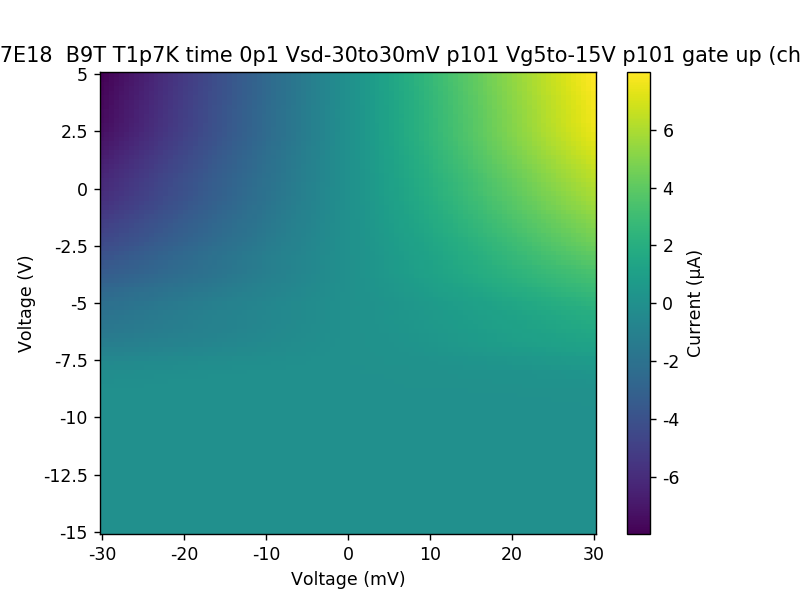

<IPython.core.display.Javascript object>


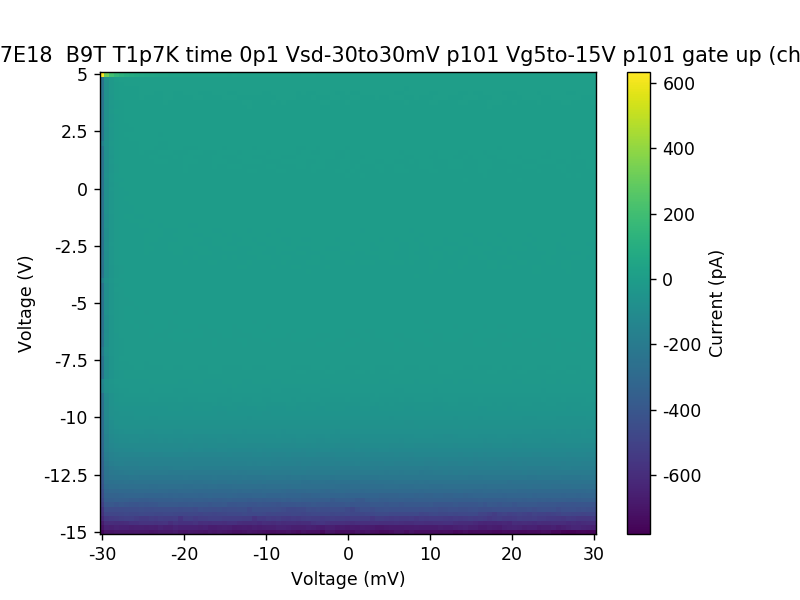

([<matplotlib.axes._subplots.AxesSubplot at 0x2793a899048>,
  <matplotlib.colorbar.Colorbar at 0x279361b0fd0>])

In [17]:
plot_by_id(3)

In [17]:
# After run setup
bias(0)
gate(0)
ppms.field_setpoint(0)
temperature(1.7)

NameError: name 'bias' is not defined

## Magnetic field ramping
We keep constant gate and bias voltage and we ramp the magnetic field with a desired rate

In [48]:
field_start  = -0.25 #T
field_end    = +0.25 #T
Nfieldpoints = 251
time_delay   = 1 #sec

do1d(ppms.field_setpoint, field_start, field_end, Nfieldpoints, time_delay, sr830.R)

Starting experimental run with id: 24


24

In [ ]:
plot_by_id(24)

In [85]:
# After run setup
#bias(0)
gate(0)
ppms.field_setpoint(0)
temperature(1.7)

TypeError: 'float' object is not callable

## Zero-Bias pinch-off curves AC

In [50]:
#after the frequancy，time constant, sensitivity were fixed, we would like to sweep the Gata voltaga to get the pinch-off curves at zero bias at 
#since it is zero bias measurement, we just need Keithley to provide a gate voltage. By sweeping the gata voltage and measure the differtial
# conductance through lock-in, we can get the curve of differential conductance as a function of gate voltage at zero bias.

# use Sinout from Lockin as AC excitation, after a device and a current amplifier, use the single as input to the lock-in, and 
#then get X,Y,R,P from Lock-in. 
#how to generate a AC signal (amplitute and frquancy)

#I typically set the time constant to 0.1s and the filter roll-off to 24dB/Oct.  
#Then I usually just sweep as fast as is possible (i.e. delay = 0), and this usually works ok.


#----------define new names for Keithley channels----------------------------------   
gate = keith.smub.volt
leakage = keith.smub.curr

#----------define new names for SR830 channels----------------------------------   
chan_a = sr830.R
chan_b = sr830.P

# ----set up equipment parapmeters----------------------------------------------------------------------
temperature = 1.7 #K
magnetic_field = 0.000 *1e-3 # mT

# ----set up lock-in parapmeters----------------------------------------------------------------------
#time_constant = 0.01 # s
#sensitivity = 1000 *1e-3 # V
#frequency = 15 # Hz
#filter_slope = 18 # dB
#amplitude = 1 # V 

# ----set up Keithley parapmeters----------------------------------------------------------------------
gate_start = -2 #V
gate_end = 5 #V
Npoints = 301
timedelay = 0.1 # s

# ----set up amplifier parapmeters----------------------------------------------------------------------
dividerAC = 1e8       # the AC voltgade divider
gain = 1e6        # gain of the current amplifier gain=V/I used 

Experiment_name = 'S29D25_B0T_Vg-2to5V Scan'
Sample_name = 'MQML22He1HB4'
new_experiment(name='MQML22He1HB4', sample_name='S29D25_HR28LR27_XAØØXBØØ_B0T_Vg-2to5V Scan')

meas = Measurement()
#meas.write_period = timedelay

# -----register parameters--------------------------------------------------------------------------------

meas = Measurement()
meas.register_parameter(gate)# register independent parameter
meas.register_parameter(leakage, setpoints=(gate,))  # now register the dependent parameter
meas.register_parameter(chan_a, setpoints=(gate,)) # now register the dependent parameter
meas.register_parameter(chan_b, setpoints=(gate,)) # now register the dependent parameter

#-----setting initial and ending state of the equipment---------------------------------------------------

meas.add_before_run(lambda: ppms.field_setpoint(magnetic_field), ())  # set magnetic field
meas.add_before_run(lambda: ppms.temperature_setpoint(temperature), ())  # set temperature
meas.add_before_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize
#meas.add_before_run(lambda: wait_for_temp(), ())  # wait for temperature to stabilize
meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s

meas.add_before_run(lambda: keith.smub.output('on'), ())  # Turn Keithley output B on
#meas.add_before_run(lambda: sr830.time_constant(time_constant), ()) # set time constant on the lock-in
#meas.add_before_run(lambda: sr830.sensitivity(sensitivity), ()) # set sensitivity on the lock-in
#meas.add_before_run(lambda: sr830.frequency(frequency), ()) # set frequency on the lock-in
#meas.add_before_run(lambda: sr830.amplitude(amplitude), ()) # set amplitude on the lock-in
#meas.add_before_run(lambda: sr830.filter_slope(filter_slope), ()) # set filter slope on the lock-in


#meas.add_after_run(lambda: gate(0), ())  # Set gate to 0
#meas.add_after_run(lambda: keith.smub.output('off'), ())  # Turn Keithley output B off

#meas.add_after_run(lambda: ppms.field_setpoint(0), ())  # set magnetic field
#meas.add_after_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize


#-----measurement----------------------------------------------------------------------------------------

new_experiment(name=Experiment_name+' up', sample_name=Sample_name)
with meas.run() as datasaver:
    for gate_setpoint in np.linspace(gate_start, gate_end, Npoints):
        gate(gate_setpoint)
        V_g = gate()
        I_g = leakage()
        R = chan_a()
        P = chan_b()
        datasaver.add_result((gate, V_g),(leakage, I_g),(chan_a, R), (chan_b, P))
#        time.sleep(timedelay) 
    dataid_up = datasaver.run_id  # convenient to have for plotting 

# Plotting the measured data for sweeping up
# PLOT 1: R-V
# PLOT 2: T-V           
dataset = qc.load_by_id(dataid_up)
labels = dataset.parameters.split(",")

v = flatten_1D_data_for_plot(dataset.get_data(labels[0])) # V
r = flatten_1D_data_for_plot(dataset.get_data(labels[2])) # V
t = flatten_1D_data_for_plot(dataset.get_data(labels[3])) # degrees

plt.figure(fig.number)
ax.set_xlabel(r'Gate voltage $V_g$, V')
ax.set_ylabel(r'Amplitude, $V$, R')
ax.plot(v,r,'b-')
fig.canvas.draw()

plt.figure(fig2.number)
ax2.set_xlabel(r'Gate voltage $V_g$, V')
ax2.set_ylabel(r'Theta, $degrees$,\theta')
ax2.plot(v,t,'b-')  
fig2.canvas.draw()


new_experiment(name=Experiment_name+' down', sample_name=Sample_name)
with meas.run() as datasaver:
    for gate_setpoint in np.linspace(gate_end, gate_start, Npoints):
        gate(gate_setpoint)
        V_g = gate()
        I_g = leakage()
        R = chan_a()
        P = chan_b()
        datasaver.add_result((gate, V_g),(leakage, I_g),(chan_a, R), (chan_b, P))
#        time.sleep(timedelay) 
    dataid_down = datasaver.run_id  # convenient to have for plotting 

        
# Plotting the measured data for sweeping down om the same plots with sweep up
# PLOT 1: R-V
# PLOT 2: T-V            
dataset = qc.load_by_id(dataid_down)
labels = dataset.parameters.split(",")

v = flatten_1D_data_for_plot(dataset.get_data(labels[0])) # V
r = flatten_1D_data_for_plot(dataset.get_data(labels[2])) # V
t = flatten_1D_data_for_plot(dataset.get_data(labels[3])) # degrees

plt.figure(fig.number)
plt.title(str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name)
ax.plot(v,r,'r-')
fig.canvas.draw()
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+' r.png', bbox_inches='tight')
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+' r.svg')

plt.figure(fig2.number)
plt.title(str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name)
ax2.plot(v,t,'r-')  
fig2.canvas.draw()
#plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+' th.png', bbox_inches='tight')
#plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+' th.svg')

field ready
Starting experimental run with id: 39
field ready
Starting experimental run with id: 40


## 2D plot of differential conductance as a function of Bias and gate
we get R and the we need to calculate differential conductance as: g=Iac/Vac
where Iac = R/gain
and   Vac = amplitude*dividerAC

In [ ]:
# After run setup
gate(0)
ppms.field_setpoint(0)
#bias(0)
#temperature(1.7)

waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting fo

<IPython.core.display.Javascript object>


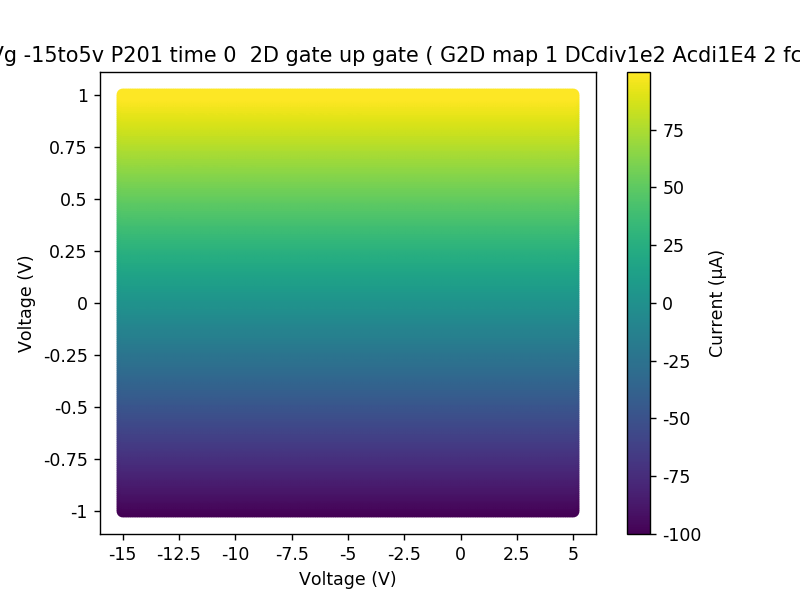

<IPython.core.display.Javascript object>


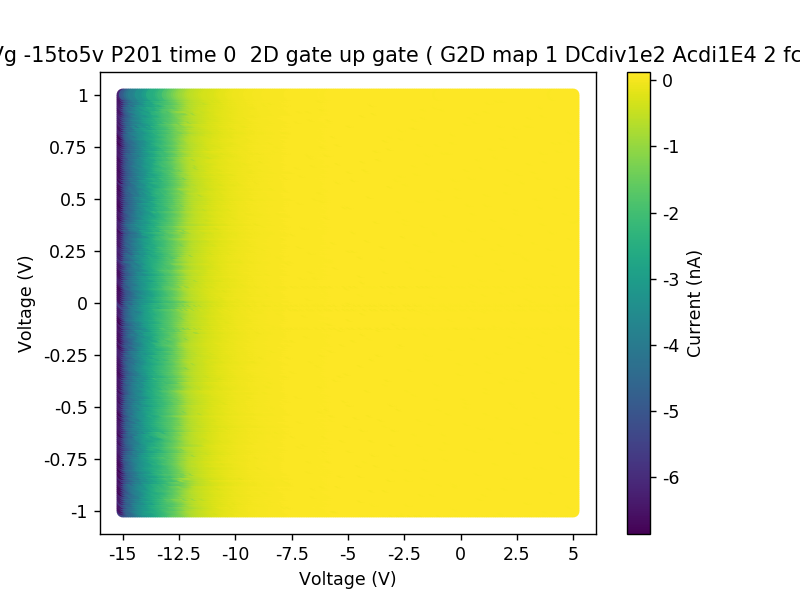

<IPython.core.display.Javascript object>


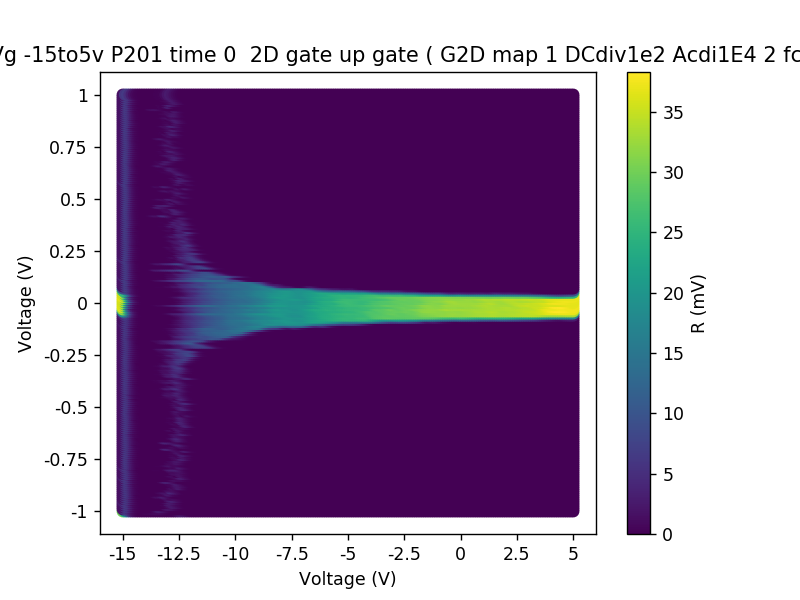

<IPython.core.display.Javascript object>


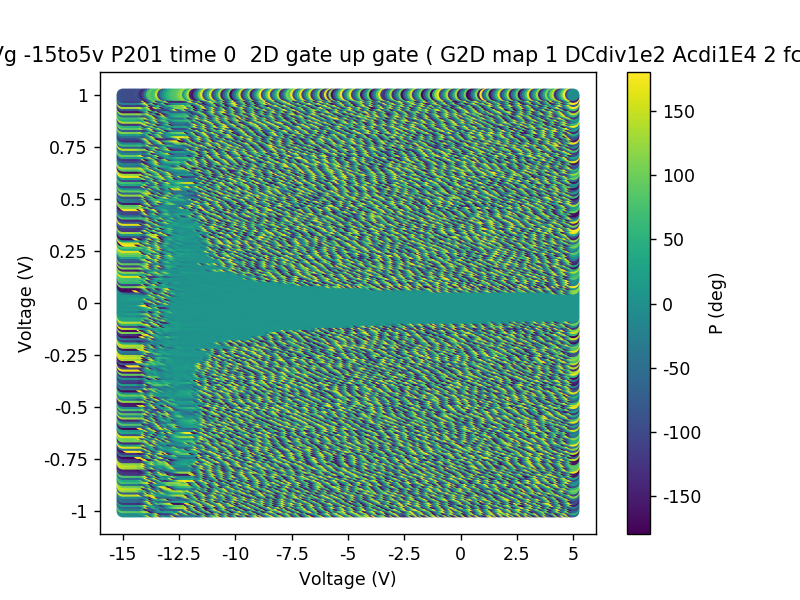

waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting fo

<IPython.core.display.Javascript object>


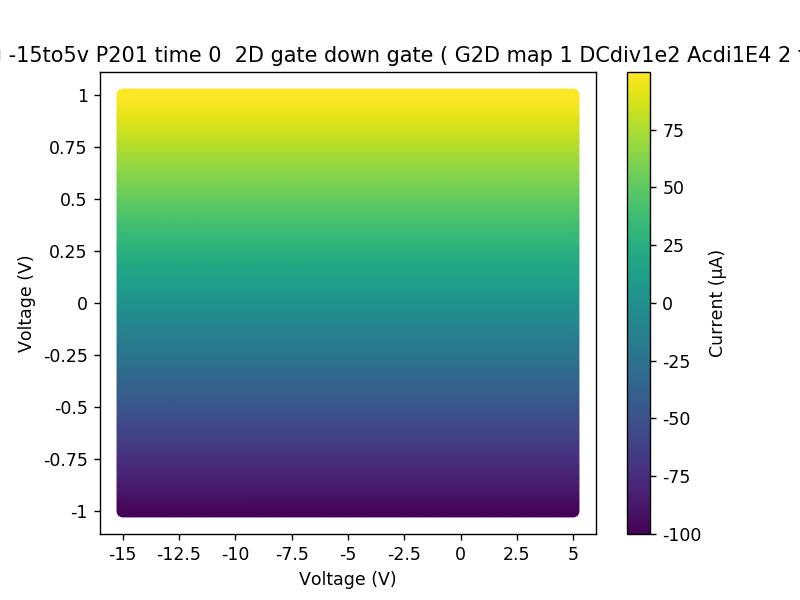

<IPython.core.display.Javascript object>


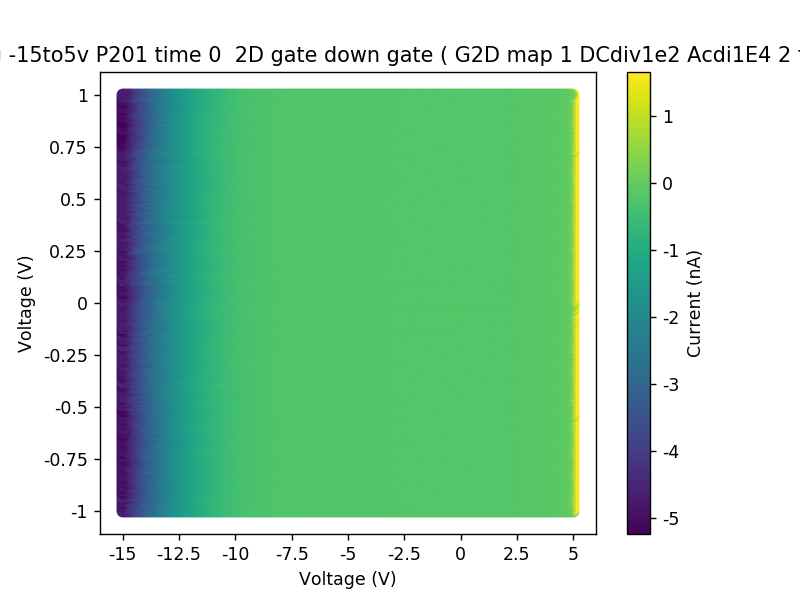

<IPython.core.display.Javascript object>


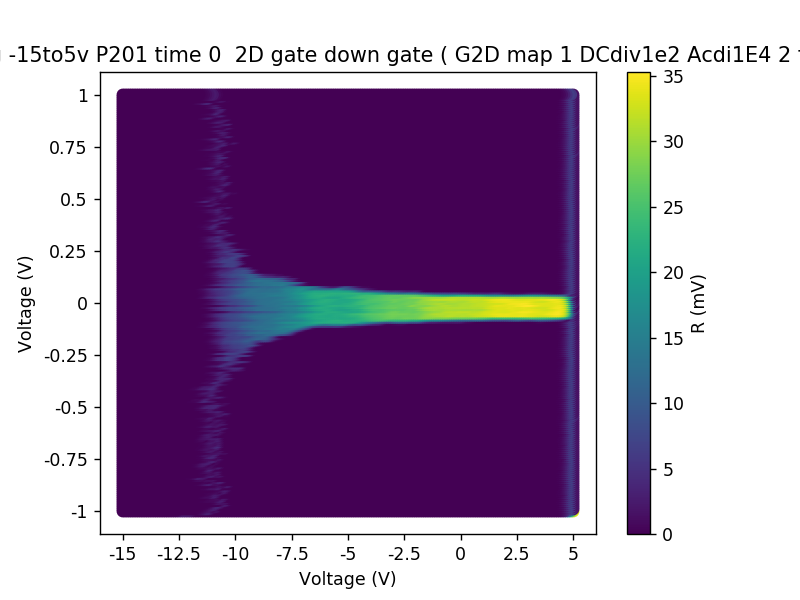

<IPython.core.display.Javascript object>


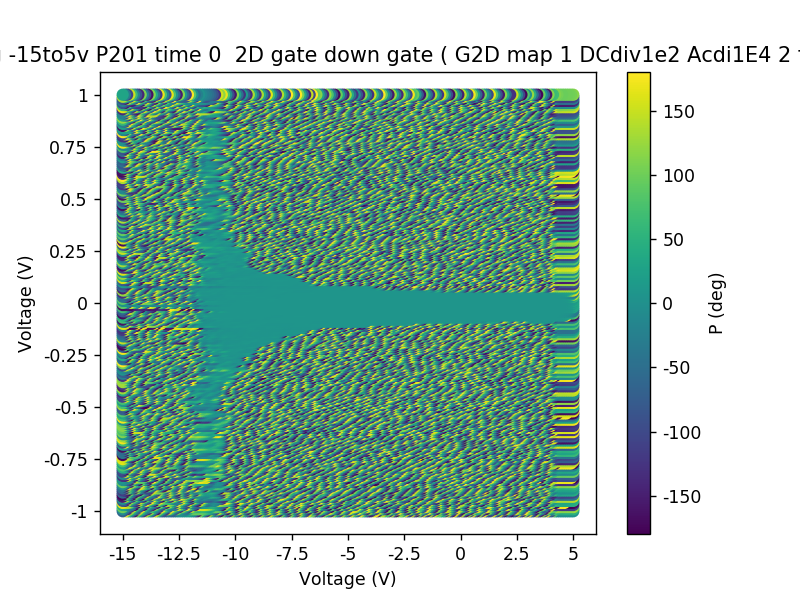

In [6]:
# when a nice plateau were obtianed at specific B, we would like to have the 2D map of differetial conductance as a function of 
# source-drain voltage and gate voltage. in this case we have to use Keithly to provide both the DC source-drain voltaga
# and gate voltage. for the device, the Sourece drain voltage would be the sum of DC voltgae from Keithley and 
# AC voltage from Lock-in. The differential conductance  g = dI/dV is measured using a standard lock-in technique. 


#2D plot of differential condcuctance as a function of bias and gate using Lock-in amplifier

#----------define new names for Keithley channels----------------------------------   
bias=keith.smua.volt
current = keith.smua.curr
gate=keith.smub.volt
leakage = keith.smub.curr

#----------define new names for SR830 channels----------------------------------   
chan_a = sr830.R
chan_b = sr830.P

# ----set up equipment parapmeters----------------------------------------------------------------------
temperature = 1.7 #K
magnetic_field = 9 #T

# ----set up lock-in parapmeters----------------------------------------------------------------------
time_constant = 100 * 1e-3 # ms
sensitivity = 100 * 1e-3 # mV
frequency = 15 # Hz
amplitude = 1 # V 

# ----set up Keithley parapmeters----------------------------------------------------------------------
gate_start = -15 #V
gate_end = 5 #V
gate_Npoints = 201

bias_start = -1000 * 1e-3 # mV
bias_end = 1000 *  1e-3 # mV
bias_Npoints = 201
#timedelaygate = 0.1 #
#timedelaybias = 0.1 #

# ----set up amplifier parapmeters----------------------------------------------------------------------
dividerDC = 1e-2       # the DC voltgade divider
dividerAC = 1e-4       # the AC voltgade divider
gain = 1e6        # gain of the current amplifier gain=V/I used 


Experiment_name = 'E4E5  B9T T1p7K  Vsd -1000to1000mV p201 time 0 Vg -15to5v P201 time 0 '
Sample_name = " G2D map 1 DCdiv1e2 Acdi1E4 2 fcut 300HZ gain1e6 3 F15HZ Am1v sen100mv tico100ms 24dBpoct"


# -----register parameters--------------------------------------------------------------------------------

meas = Measurement()

#meas.write_period = timedelay-------------what this is for ?

meas.register_parameter(gate)  # register the first independent parameter
meas.register_parameter(bias)  # register the first independent parameter
meas.register_parameter(current, setpoints=(gate,bias,))  # now register the dependent one
meas.register_parameter(leakage, setpoints=(gate,bias,))  # now register the dependent parameter
meas.register_parameter(chan_a, setpoints=(gate,bias,)) # now register the dependent parameter
meas.register_parameter(chan_b, setpoints=(gate,bias,)) # now register the dependent parameter

#-----setting initial and ending state of the equipment---------------------------------------------------

meas.add_before_run(lambda: ppms.field_setpoint(magnetic_field), ())  # set magnetic field
meas.add_before_run(lambda: ppms.temperature_setpoint(temperature), ())  # set temperature
meas.add_before_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize
meas.add_before_run(lambda: wait_for_temp(), ())  # wait for temperature to stabilize
meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s

meas.add_before_run(lambda: keith.smua.output('on'), ())  # Turn Keithley output A on
meas.add_before_run(lambda: keith.smub.output('on'), ())  # Turn Keithley output B on

meas.add_before_run(lambda: sr830.time_constant(time_constant), ()) # set time constant on the lock-in
meas.add_before_run(lambda: sr830.sensitivity(sensitivity), ()) # set sensitivity on the lock-in
meas.add_before_run(lambda: sr830.frequency(frequency), ()) # set frequency on the lock-in
meas.add_before_run(lambda: sr830.amplitude(amplitude), ()) # set amplitude on the lock-in
#meas.add_before_run(lambda: bias(bias_setpoint), ())  # set bias to defined value

meas.add_after_run(lambda: gate(0), ())  # Set gate to 0
meas.add_after_run(lambda: bias(0), ())  # Set bias to 0
meas.add_after_run(lambda: keith.smua.output('off'), ())  # Turn Keithley output A off
meas.add_after_run(lambda: keith.smub.output('off'), ())  # Turn Keithley output B off

meas.add_after_run(lambda: ppms.field_setpoint(0), ())  # set magnetic field
meas.add_after_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize


#------------------------------------------------------------------------------------------------------------
new_experiment(name=Experiment_name+' 2D gate up gate', sample_name=Sample_name)
with meas.run() as datasaver:
    run_id = datasaver.run_id

    for bias_setpoint in np.linspace(bias_start, bias_end, bias_Npoints): 
        bias(bias_setpoint)
        for gate_setpoint in np.linspace(gate_start, gate_end, gate_Npoints) :
            gate(gate_setpoint)
            V_g = gate()
            V_sd = bias()
            I_sd = current()
            I_g = leakage()
            R = chan_a()
            P = chan_b()
            datasaver.add_result((gate, V_g),
                                 (bias, V_sd),
                                 (current, I_sd),
                                 (leakage, I_g),
                                 (chan_a, R),
                                 (chan_b, P))
#            time.sleep(timedelaybias) 

            

plot_by_id(run_id)

#--------------------------------------------------------------------------------------------------------------------
new_experiment(name=Experiment_name+' 2D gate down gate', sample_name=Sample_name)
with meas.run() as datasaver:
    run_id = datasaver.run_id
    
    for bias_setpoint in np.linspace(bias_start, bias_end, bias_Npoints): 
        bias(bias_setpoint)
        for gate_setpoint in np.linspace(gate_end, gate_start, gate_Npoints):
            gate(gate_setpoint)
            V_g = gate()
            V_sd = bias()
            I_sd = current()
            I_g = leakage()
            R = chan_a()
            P = chan_b()
            datasaver.add_result((gate, V_g),
                                 (bias, V_sd),
                                 (current, I_sd),
                                 (leakage, I_g),
                                 (chan_a, R),
                                 (chan_b, P))
#            time.sleep(timedelaybias) 
            

plot_by_id(run_id)

meas.add_after_run(lambda: ppms.field_setpoint(0), ())  # set magnetic field
meas.add_after_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize


# through lock-in we can get the AC output voltage, and then by the gain of the current amplifier, we can get the AC output current. 
# we know the AC voltage applied on the device, then we can get the differential conductance by g=Vac/Iac. 
# shall we measure the DC current at the same time? if yes, how. by Keithlay?
# we should also extract the theta from Lock-in, so that we know we are meaesure the resistance instead of capacitance.

## 2D plot of differential conductance as a function of Magnetic filed and gate under 0 bias
we get R and need to calculate differential conductance. [first cell]: Code runs for increasing steps of the magnetic field with sweep up and then with decreasing steps of the magnetic field and sweep down . [second cell]: it only runs increasing steps and sweep up.

Starting experimental run with id: 87
field ready
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
field ready
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
wa

<IPython.core.display.Javascript object>


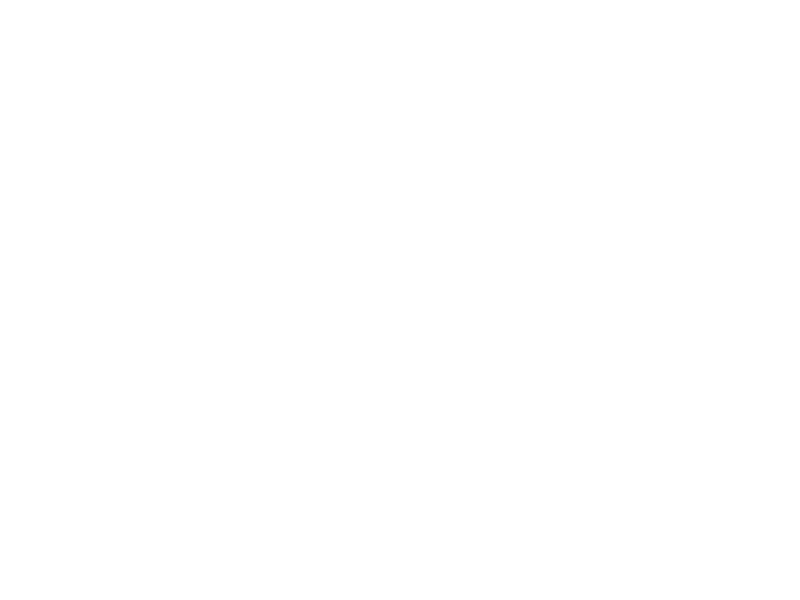

<IPython.core.display.Javascript object>


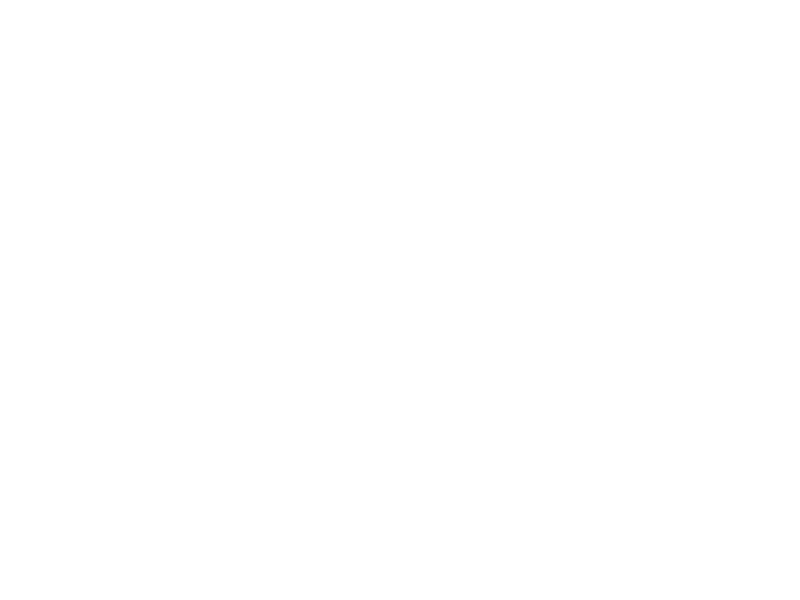

<IPython.core.display.Javascript object>


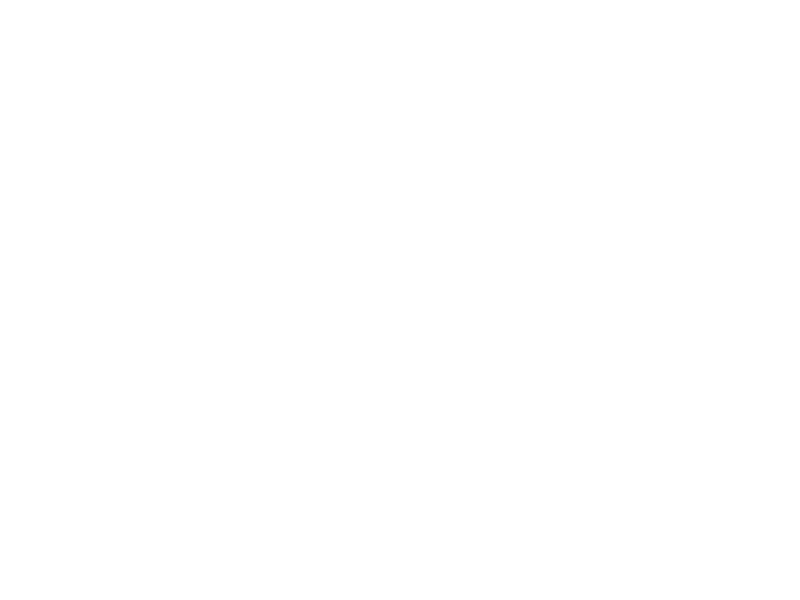

Starting experimental run with id: 88
field ready
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
field ready
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
wa

KeyboardInterrupt: 

In [8]:
#----------define new names for Keithley channels----------------------------------   
gate=keith.smub.volt
leakage = keith.smub.curr
 
#----------define new names for PPMS ----------------------------------   
Mag = ppms.field
MagSet = ppms.field_setpoint
 
#----------define new names for SR830 channels----------------------------------   
chan_a = sr830.R
chan_b = sr830.P
 
# ----set up equipment parapmeters----------------------------------------------------------------------
temperature = 1.7 #K
 
# ----set up lock-in parapmeters----------------------------------------------------------------------
time_constant = 100 *1e-3 # ms
sensitivity = 100 *1e-3 # mV
frequency = 15 # Hz
amplitude = 1 # V 
 
# ----set up Keithley parapmeters----------------------------------------------------------------------
gate_start = -15 #V
gate_end = 5 #V
gate_Npoints = 201
 
Mag_start = 0  # T
Mag_end = 9  # T
Mag_Npoints = 10
timedelay  = 5
# ----set up amplifier parapmeters----------------------------------------------------------------------
dividerDC = 1e-2       # the DC voltgade divider
dividerAC = 1e-4       # the AC voltgade divider
gain = 10e6        # gain of the current amplifier gain=V/I used 
 
Experiment_name = 'E4E5 T1p7K B0to9T p10 time5s Vg15to5v P201 time 0 '
Sample_name = " G2D map 1 DCdiv1e2 Acdi1E4 2 fcut 300HZ gain1e6 3 F15HZ Am1v sen100mv tico100ms 24dBpoct"
 
# -----register parameters--------------------------------------------------------------------------------
meas = Measurement()
meas.register_parameter(gate)  # register the first independent parameter
meas.register_parameter(Mag)  # register the first independent parameter
meas.register_parameter(leakage, setpoints=(gate,Mag,))  # now register the dependent parameter
meas.register_parameter(chan_a, setpoints=(gate,Mag,)) # now register the dependent parameter
meas.register_parameter(chan_b, setpoints=(gate,Mag,)) # now register the dependent parameter

meas.add_before_run(lambda: keith.smub.output('on'), ())  # Turn Keithley output B on

meas.add_before_run(lambda: sr830.time_constant(time_constant), ()) # set time constant on the lock-in
meas.add_before_run(lambda: sr830.sensitivity(sensitivity), ()) # set sensitivity on the lock-in
meas.add_before_run(lambda: sr830.frequency(frequency), ()) # set frequency on the lock-in
meas.add_before_run(lambda: sr830.amplitude(amplitude), ()) # set amplitude on the lock-in

meas.add_after_run(lambda: gate(0), ())  # Set gate to 0
meas.add_after_run(lambda: keith.smub.output('off'), ())  # Turn Keithley output B off

#meas.add_after_run(lambda: ppms.field_setpoint(0), ())  # set magnetic field
#meas.add_after_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize
 
#------------------------------------------------------------------------------------------------------------
new_experiment(name=Experiment_name+' 2D E11E12 sweep B first', sample_name=Sample_name)
with meas.run() as datasaver:
    run_id = datasaver.run_id
 
    for Mag_setpoint in np.linspace(Mag_start, Mag_end, Mag_Npoints): 
        MagSet(Mag_setpoint)
        wait_for_field()
        time.sleep(timedelay)
        for gate_setpoint in np.linspace(gate_start, gate_end, gate_Npoints) :
            gate(gate_setpoint)
            V_g = gate()
            B = Mag()
            I_g = leakage()
            R = chan_a()
            P = chan_b()
            datasaver.add_result((gate, V_g),
                                 (Mag, B),
                                 (leakage, I_g),
                                 (chan_a, R),
                                 (chan_b, P))
             
plot_by_id(run_id)
            
            
new_experiment(name=Experiment_name+' 2D E11E12 sweep B first de', sample_name=Sample_name)
with meas.run() as datasaver:
    run_id = datasaver.run_id    
    
    for Mag_setpoint in np.linspace(Mag_end, Mag_start, Mag_Npoints): 
        MagSet(Mag_setpoint)
        wait_for_field()
        time.sleep(timedelay)
        for gate_setpoint in np.linspace(gate_end, gate_start, gate_Npoints) :
            gate(gate_setpoint)
            V_g = gate()
            B = Mag()
            I_g = leakage()
            R = chan_a()
            P = chan_b()
            datasaver.add_result((gate, V_g),
                                 (Mag, B),
                                 (leakage, I_g),
                                 (chan_a, R),
                                 (chan_b, P))
 
    
             
plot_by_id(run_id)






Starting experimental run with id: 85
field ready
waiting for field
field ready
waiting for field
field ready
field ready
field ready
field ready
waiting for field
field ready
field ready
waiting for field
field ready
field ready
waiting for field
field ready
field ready
field ready
field ready
waiting for field
field ready
field ready
waiting for field
field ready
field ready
waiting for field
field ready
field ready
waiting for field
field ready
field ready
waiting for field
field ready
field ready
waiting for field
field ready
field ready
field ready
field ready
waiting for field
field ready
field ready
field ready
waiting for field
field ready
field ready
field ready
waiting for field
field ready
field ready
waiting for field
field ready
waiting for field
field ready
field ready
field ready
field ready
waiting for field
field ready
field ready
waiting for field
field ready
field ready
waiting for field
field ready
field ready
waiting for field
field ready
field ready
waiting for fi

field ready
waiting for field
field ready
waiting for field
field ready
waiting for field
field ready
waiting for field
field ready
waiting for field
field ready
waiting for field
field ready
waiting for field
field ready
waiting for field
field ready
waiting for field
field ready
waiting for field
field ready
waiting for field
field ready
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting for field
waiting fo

<IPython.core.display.Javascript object>


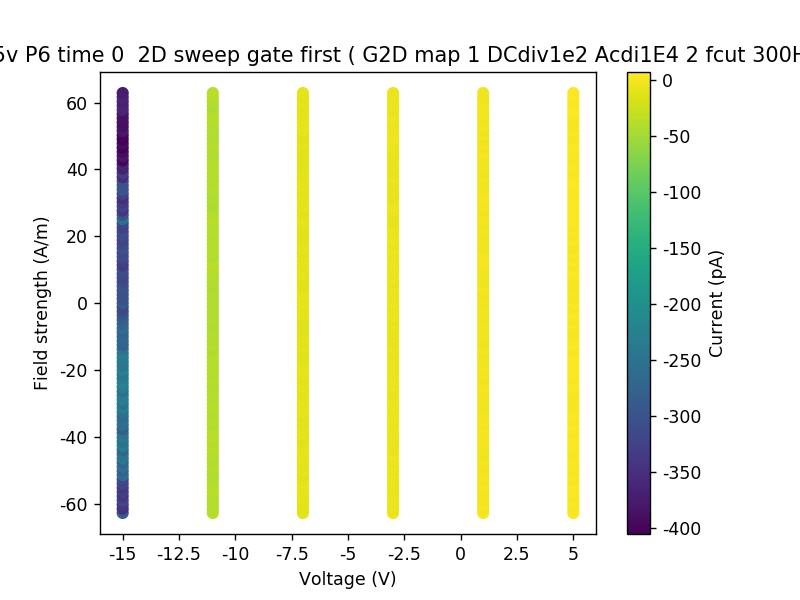

<IPython.core.display.Javascript object>


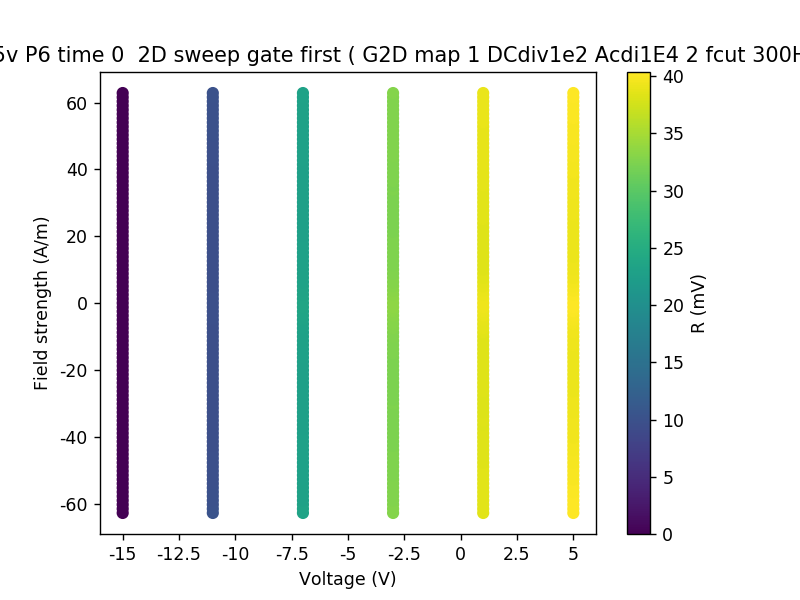

<IPython.core.display.Javascript object>


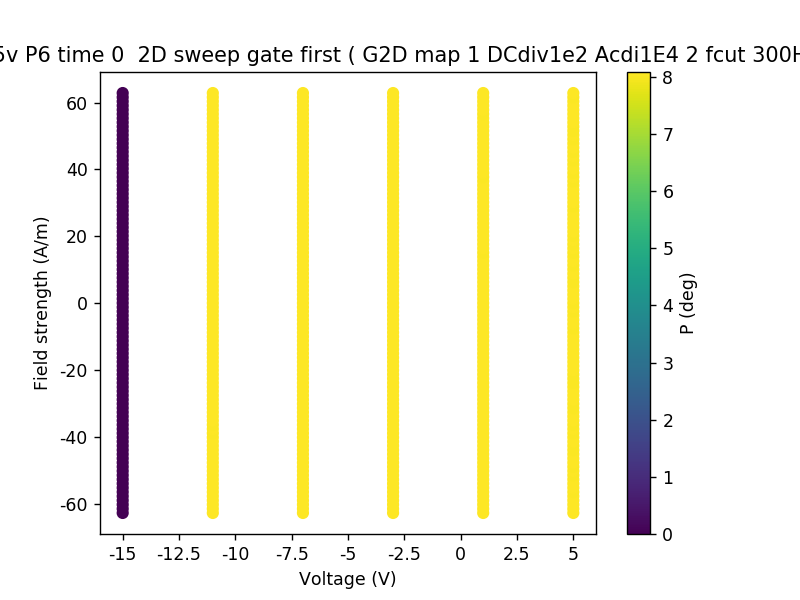

([<matplotlib.axes._subplots.AxesSubplot at 0x1588e4fb198>,
  <matplotlib.colorbar.Colorbar at 0x1588e632668>])

In [6]:
#----------define new names for Keithley channels----------------------------------   
gate=keith.smub.volt
leakage = keith.smub.curr
 
#----------define new names for PPMS ----------------------------------   
Mag = ppms.field
MagSet = ppms.field_setpoint
 
#----------define new names for SR830 channels----------------------------------   
chan_a = sr830.R
chan_b = sr830.P
 
# ----set up equipment parapmeters----------------------------------------------------------------------
temperature = 1.7 #K
 
# ----set up lock-in parapmeters----------------------------------------------------------------------
time_constant = 100 *1e-3 # ms
sensitivity = 100 *1e-3 # mV
frequency = 15 # Hz
amplitude = 1 # V 
 
# ----set up Keithley parapmeters----------------------------------------------------------------------
gate_start = -15 #V
gate_end = 5 #V
gate_Npoints = 6
 
Mag_start = -0.5  # T
Mag_end = 0.5  # T
Mag_Npoints = 101
timedelay  = 5
# ----set up amplifier parapmeters----------------------------------------------------------------------
dividerDC = 1e-2       # the DC voltgade divider
dividerAC = 1e-4       # the AC voltgade divider
gain = 10e6        # gain of the current amplifier gain=V/I used 
 
Experiment_name = 'E4E5 T1p7K B-0P5to0P5T p101 time5s Vg15to5v P6 time 0 '
Sample_name = " G2D map 1 DCdiv1e2 Acdi1E4 2 fcut 300HZ gain1e6 3 F15HZ Am1v sen100mv tico100ms 24dBpoct"
 
# -----register parameters--------------------------------------------------------------------------------
meas = Measurement()
meas.register_parameter(gate)  # register the first independent parameter
meas.register_parameter(Mag)  # register the first independent parameter
meas.register_parameter(leakage, setpoints=(gate,Mag,))  # now register the dependent parameter
meas.register_parameter(chan_a, setpoints=(gate,Mag,)) # now register the dependent parameter
meas.register_parameter(chan_b, setpoints=(gate,Mag,)) # now register the dependent parameter

meas.add_before_run(lambda: keith.smub.output('on'), ())  # Turn Keithley output B on

meas.add_before_run(lambda: sr830.time_constant(time_constant), ()) # set time constant on the lock-in
meas.add_before_run(lambda: sr830.sensitivity(sensitivity), ()) # set sensitivity on the lock-in
meas.add_before_run(lambda: sr830.frequency(frequency), ()) # set frequency on the lock-in
meas.add_before_run(lambda: sr830.amplitude(amplitude), ()) # set amplitude on the lock-in

meas.add_after_run(lambda: gate(0), ())  # Set gate to 0
meas.add_after_run(lambda: keith.smub.output('off'), ())  # Turn Keithley output B off

#meas.add_after_run(lambda: ppms.field_setpoint(0), ())  # set magnetic field
#meas.add_after_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize
 
#------------------------------------------------------------------------------------------------------------
new_experiment(name=Experiment_name+' 2D sweep gate first', sample_name=Sample_name)
with meas.run() as datasaver:
    run_id = datasaver.run_id
 
    for gate_setpoint in np.linspace(gate_start, gate_end, gate_Npoints) :
        gate(gate_setpoint)
        for Mag_setpoint in np.linspace(Mag_start, Mag_end, Mag_Npoints): 
            MagSet(Mag_setpoint)
            wait_for_field()
            time.sleep(timedelay)
            V_g = gate()
            B = Mag()
            I_g = leakage()
            R = chan_a()
            P = chan_b()
            datasaver.add_result((gate, V_g),
                                 (Mag, B),
                                 (leakage, I_g),
                                 (chan_a, R),
                                 (chan_b, P))
             
plot_by_id(run_id)
            



## 2D mapping by loadind (not ready yet)
It calculates differential conductance from R and plots in 2D

In [ ]:
map_dataset = get_data_by_id(run_id)

V_gate = map_dataset[0][0]['data']
V_bias = map_dataset[1][0]['data']
R_amplitude = map_dataset[2][1]['data']
DIDV_diff_conductance = []

n = 0
for lists in R_amplitude:
    DIDV_diff_conductance.append([])
    for vals in lists:
        cond = （vals/gain）/ （amplitude*dividerAC）
        cond.append(DIDV_diff_conductance[n])
    n = n+1

fig, ax = plt.subplots()    
c = ax.pcolormesh(V_gate, V_bias, DIDV_diff_conductance, cmap='RdBu')
ax.set_title('Differential Conductance')
fig.colorbar(DIDV_diff_conductance, ax=ax)
plt.show()

## Loading old data 

[[{'name': 'ppms_cryostat_field', 'label': 'Field strength', 'unit': 'A/m', 'data': array([100.53092392, 100.53077052, 100.53077052, 100.52968446,
       100.52937153])}, {'name': 'SR830_R', 'label': 'R', 'unit': 'V', 'data': array([0.00405028, 0.00405219, 0.00404838, 0.00405028, 0.00405028])}]]


<IPython.core.display.Javascript object>


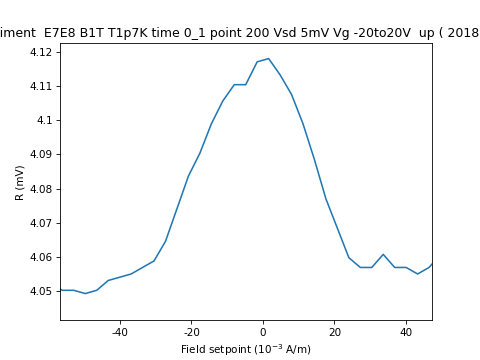

([<matplotlib.axes._subplots.AxesSubplot at 0x1d20fd56278>], [None])

In [45]:
from qcodes.dataset.data_export import get_data_by_id
#get_data_by_id?

#qc.config['core']['db_location'] = r"C:\Users\......\file.db"
#import_dat_file(qc.config['core']['db_location'])

review_dataset = get_data_by_id(dataid)

# print everything
print (review_dataset)

#Print a variable with its set (probably this is the voltage)
#[a][b][c]
# a:0,1,2,3,... example 0: 1st parameter of the (in)dependent variables
# b:0,1 -----> 0: independent parameter group, 1: dependent parameter group
# c:name,data


plot_by_id(22)

## Pinch-off curves using Keithley, voltage devider and current amplifier (Without Lock-in)
Normal sweep without live plotting. Results are shown when each sweep is finished.

In [4]:
# pinch-off curves of using Keithlay, voltgae devider and current amplifier 
# in this case, Keithlay provide a voltgae, after voltgae devider, the voltage will be applied on the device, after current amplifer
# we measured the output voltgae by Keisight. so from Keisight, we read the output voltage, then we can get the current by I=Vout/gain
# this is the current flow over the device. From keithley and voltage devidr,we know the voltage applied on the device. then we can get 
# the conductance in overoll conductance=(Voutput/gain)/(keith.smua.volt/devider)


# define new names for Keithley and keisight channels
bias_set  = keith.smua.volt
gate  = keith.smub.volt
leakage   = keith.smub.curr
bias_meas = keys.volt

# pinch-off curves of using Keithlay only

bias_setpoint = 5 * 1e-3 #mV
gate_start = -5 #V
gate_end = 5 #V
Npoints = 201

temperature = 1.7 #K
magnetic_field = 0* 1e-3 #mT

divider = 100       # the voltgade divider
gain = 1e6        # gain of the current amplifier gain=V/I used 

timedelay = 0.1 #

Experiment_name = '01_02 B0T T1p7K time0_1 point201 Vsd5mV Vg-5to5V voldivid100 gain1e6 '
Sample_name = " QDev869B "

meas = Measurement()
meas.write_period = timedelay

#----------------------------------------------------------------------------------------------------------
meas.register_parameter(gate)  # register independent parameter
meas.register_parameter(leakage, setpoints=(gate,))     # now register the dependent one
meas.register_parameter(bias_meas, setpoints=(gate,))   # now register the dependent one

meas.add_before_run(lambda: ppms.field_setpoint(magnetic_field), ())  # set magnetic field
meas.add_before_run(lambda: ppms.temperature_setpoint(temperature), ())  # set temperature
meas.add_before_run(lambda: wait_for_field(), ())  # wait for magnetic field to stabilize
meas.add_before_run(lambda: wait_for_temp(), ())  # wait for temperature to stabilize
meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s

meas.add_before_run(lambda: keith.smua.output('on'), ())  # Turn Keithley output A on
meas.add_before_run(lambda: keith.smub.output('on'), ())  # Turn Keithley output B on

meas.add_before_run(lambda: bias_set(bias_setpoint), ())  # set bias to defined value
meas.add_before_run(lambda: time.sleep(1), ())  # delay 1s

#meas.add_before_run(lambda: ppms.field_setpoint(0.1), ())  # add a set-up action
meas.add_after_run(lambda: bias_set(0), ())  # Set bias to 0
meas.add_after_run(lambda: keith.smua.output('off'), ())  # Turn Keithley output A off
meas.add_after_run(lambda: keith.smub.output('off'), ())  # Turn Keithley output B off

#----------------------------------------------------------------------------------------------------
# Sweep up gate without plotting
# This measurement just saves the gate voltage array set (not the actual value),
# the measured voltage from dmm and the gate leakage
# The output voltage will be divided by the Gain to give the current

new_experiment(name=Experiment_name+' up', sample_name = Sample_name)
with meas.run() as datasaver:
    for gate_setpoint in np.linspace(gate_start, gate_end, Npoints):
        gate(gate_setpoint)
        V_g = gate()
        V_out = bias_meas()
        I_g = leakage()
        datasaver.add_result((gate, V_g), (bias_meas, V_out), (leakage, I_g))
        time.sleep(timedelay)    #sleep
    dataid_up = datasaver.run_id  # convenient to have for plotting 

# Plotting the measured data for sweeping up
# PLOT 1: I-V
# PLOT 2: L-V  
dataset = qc.load_by_id(dataid_up)
labels = dataset.parameters.split(",")

v = flatten_1D_data_for_plot(dataset.get_data(labels[0])) # V
l = flatten_1D_data_for_plot(dataset.get_data(labels[1]))*1e9 # nA 
vout = flatten_1D_data_for_plot(dataset.get_data(labels[2]))# V

plt.figure(fig.number)
ax.plot(v,vout,'b-')  
fig.canvas.draw()

plt.figure(fig2.number)
ax2.plot(v,l,'b-')  
fig2.canvas.draw()

# Sweep down gate without plotting
# This measurement just saves the gate voltage array set (not the actual value),
# the measured current and the gate leakage
new_experiment(name=Experiment_name+' down', sample_name=Sample_name)
with meas.run() as datasaver:
    for gate_setpoint in np.linspace(gate_start, gate_end, Npoints):
        gate(gate_setpoint)
        V_g = gate()
        V_out = bias_meas()
        I_g = leakage()
        datasaver.add_result((gate, V_g), (bias_meas, V_out), (leakage, I_g))
        time.sleep(timedelay)    #sleep
    dataid_down = datasaver.run_id  # convenient to have for plotting 
        
# Plotting the measured data for sweeping down om the same plots with sweep up
# PLOT 1: I-V
# PLOT 2: L-V            
dataset = qc.load_by_id(dataid_down)
labels = dataset.parameters.split(",")

v = flatten_1D_data_for_plot(dataset.get_data(labels[0])) # V
l = flatten_1D_data_for_plot(dataset.get_data(labels[1]))*1e9 # nA 
vout = flatten_1D_data_for_plot(dataset.get_data(labels[2]))# V

plt.figure(fig.number)
plt.title(str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name)
ax.set_xlabel(r'Gate voltage $V_g$, V')
ax.set_ylabel(r'Voltage output, $V_{out}$,V')
ax.plot(v,vout,'r-')
fig.canvas.draw()
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+'.png', bbox_inches='tight')
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+'.svg')

plt.figure(fig2.number)
plt.title(str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name)
ax2.set_xlabel(r'Gate voltage $V_g$, V')
ax2.set_ylabel(r'Leackage I_g, $nA$')
ax2.plot(v,l,'r-')  
fig2.canvas.draw()
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+'.png', bbox_inches='tight')
plt.savefig(newpath + str(dataid_up)+' '+str(dataid_down)+' '+Sample_name+' '+Experiment_name+'.svg')

field ready
Starting experimental run with id: 1
field ready
Starting experimental run with id: 2


## Log Data

In [8]:
# Create the Dictionary
log = {}

log['id']    = Sample_name

log['length']      = 4000 #nm
log['width']       = 250 #nm
log['capacitance'] = 2.02e-15 * 4 #F 2.02e-15 F is for 1 um


log['location']    = 'mqml' 
log['fridge']      = 'dynacoolppms'
log['lockin']      = 'sr830' # sr830
log['sourcemeter'] = 'keithley2614bsmub'
log['multimeter']  = '' #keysight34465A
log['currentampl'] = 'physicsbaselsp983withlsk389a' # physicsbaselsp983withlsk389a
log['voltageampl'] = ''


log['voltdivac'] = dividerAC
log['voltdivdc'] = 1/1
log['gain']      = gain

log['timeconstant'] = time_constant
log['sensitivity']  = sensitivity
log['frequency']    = frequency
log['amplitude']    = amplitude
log['filter_slope']    = filter_slope


log['loadingdate']      = '20190205'
log['operator']         = 'jordan'
log['degastime']        = 10
log['degastempereture'] = 350


log['temperature'] = temperature
log['field']       = magnetic_field
log['biasvoltage'] = 0
log['gatemax']     = gate_start
log['gatemin']     = gate_end
log['points']      = Npoints
log['steps']       = float((log['gatemax']-log['gatemin'])/log['points'])
log['duration']    = 120
log['sweeprate']   = (log['gatemax']-log['gatemin'])/log['duration']
log['sweep']       = 'fwbw'

In [9]:
for key in log:
    print(key)

print('============================')
    
for key in log:
    print(log[key])

id
length
width
capacitance
location
fridge
lockin
sourcemeter
multimeter
currentampl
voltageampl
voltdivac
voltdivdc
gain
timeconstant
sensitivity
frequency
amplitude
filter_slope
loadingdate
operator
degastime
degastempereture
temperature
field
biasvoltage
gatemax
gatemin
points
steps
duration
sweeprate
sweep
qdev841ea2fe3d
4000
250
8.08e-15
mqml
dynacoolppms
sr830
keithley2614bsmub

physicsbaselsp983withlsk389a

10000.0
1.0
1000000.0
0.1
0.5
17
1
18
20190205
jordan
10
350
1.7
0
0
-5.5
5.5
501
-0.021956087824351298
120
-0.09166666666666666
fwbw


In [2]:
qc.__file__

'c:\\users\\quantum_ppms\\documents\\qcodes source\\qcodes\\qcodes\\__init__.py'

In [45]:
ppms.field_target(0.0)

ppms.ramp('non-blocking')

In [60]:
ppms.field_measured()

1.2342226691544056e-06